# Detecting Fraudulent Credit Card Transactions

In this project, we will use the creditcard.csv dataset from Kaggle to create a model to predict fraudulent credit card transactions. This dataset contains credit card transactions in September 2013 for European cardholders. First, we will import kagglehub in order to download the data source and store it in my C Drive. Source: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

In [22]:
# Import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score

In [3]:
# Next, let's download the dataset from Kaggle
import kagglehub

# Download latest version
source_path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", source_path)

Path to dataset files: C:\Users\sarah\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3


Next, we will load the dataset into pandas data frame.

In [4]:
# Load the dataset
df = pd.read_csv(f"{source_path}\creditcard.csv")

In [5]:
# Display the first 5 rows of the dataset
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7   
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599  \
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25   
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539  \
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

Class will be our Y (target variable) whereas all other columns will be features. Per Kaggle's documentation, variables V1 through V28 have been transformed and no further information can be provided due to confidentiality issues. We will move forward with profiling our dataset.

1. Get the number of rows and columns, data types, check for missing values
2. Get a frequency of how many transactions were fraud (Class=1) vs not fraud (Class=0).
3. Get a frequency of Time elapsed between transactions (how many 0s, 1s, 2s, etc.)

In [6]:
# Get the shape of the dataset
print("Shape of the dataset:", df.shape)

Shape of the dataset: (284807, 31)


In [7]:
# Get the data types of the columns
print("Data types of the columns:" , df.dtypes)

Data types of the columns: Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


In [8]:
# Get the number of missing values in each column
print("Number of missing values in each column:", df.isnull().sum())

Number of missing values in each column: Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [9]:
# Get a frequency count of the target variable
print("Frequency count of the target variable:", df['Class'].value_counts())

Frequency count of the target variable: Class
0    284315
1       492
Name: count, dtype: int64


In [10]:
# Get a frequency count of the one of the features Time
print("Frequency count of the feature Time:", df['Time'].value_counts())

Frequency count of the feature Time: Time
163152.0    36
64947.0     26
68780.0     25
3767.0      21
3770.0      20
            ..
127750.0     1
62260.0      1
62259.0      1
127753.0     1
172792.0     1
Name: count, Length: 124592, dtype: int64


## Preparing Data for Logistic Regression Analysis
Our target variable is a binary variable (0 = not fraudulent, 1 = fraudulent), which indicates that we should use the logistic regression model to predict the odds of a fraudulent transaction.

First, we'll divide our data into x_data and y_data parameters. Our x_data will contain all attributes we're using to predict the target ('Class'), and the y_data will be the target 'Class'.

In [11]:
y_data = df['Class']
x_data = df.drop('Class', axis=1) #specify axis = 1 to drop the 'Class' column

Based on recommended industry practices, we will proceed with a 90:10 train test split ratio for logistic regression.
Source: doi: 10.7717/peerj-cs.2245
https://pmc.ncbi.nlm.nih.gov/articles/PMC11419616

In [32]:
# create training and test dataset for logistic regression
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.10, random_state=42)
print("Number of training records:",x_train.shape[0])
print("Number of test records:", x_test.shape[0])

Number of training records: 256326
Number of test records: 28481


Create mutliple arrays and reshape x_train for each feature.

In [52]:
# create variable for V1 from the training dataset
x_train_v1 = x_train['V1'].values.reshape(-1, 1)
# create variable for V1 from the test dataset
x_test_v1 = x_test['V1'].values.reshape(-1, 1)
# create variable for V2 from the training dataset
x_train_v2 = x_train['V2'].values.reshape(-1, 1)
# create variable for V2 from the test dataset
x_test_v2 = x_test['V2'].values.reshape(-1, 1)

Let's create the logistic regression object.

In [53]:
# logm = LogisticRegression()
logm = LogisticRegression(max_iter=1000)  # Increase max_iter to 1000 to allow model to converge
logm

LogisticRegression(max_iter=1000)

Now, we create and train/fit the linear model, starting with feature V1.

In [54]:
# logm.fit(x_train, y_train)
logm.fit(x_train_v1, y_train)

LogisticRegression(max_iter=1000)

Let's make a prediction on the test set starting with feature V1.

In [55]:
# Make predictions on the test set
yhat = logm.predict(x_test_v1)

Next, let's calculate the accuracy of our first logistic model.

In [56]:
# Calculate accuracy
accuracy = accuracy_score(y_test, yhat)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


Print the model coefficients and intercept

In [65]:
# Print model coefficients and intercept
print(f"Coefficient: {logm.coef_[0][0]:.2f}")
print(f"Intercept: {logm.intercept_[0]:.2f}")

Coefficient: -0.22
Intercept: -6.60


Let's now plot the logistic regression curve against the training data points.

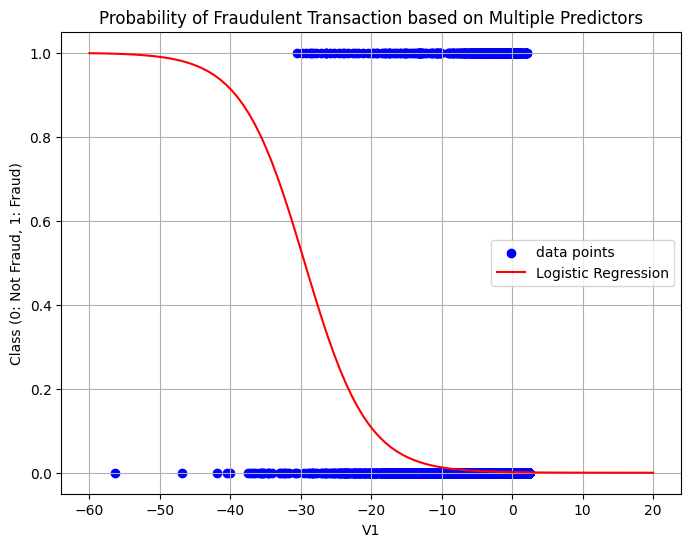

In [ ]:
# Plot the data points and the logistic regression curve
plt.figure(figsize=(8, 6))
plt.scatter(x_train_v1, y_train, color='blue', label='data points')

# Generate x values for plotting the sigmoid function
X_plot = np.linspace(-60, 20, 100).reshape(-1, 1) # The values of linspace() are based on the min and max of the selected feature V1
# Predict probabilities for the x values
y_proba = logm.predict_proba(X_plot)[:, 1]
plt.plot(X_plot, y_proba, color='red', label='Logistic Regression')

# Set X and Y axis labels, Title and Legend
plt.xlabel('V1')
plt.ylabel('Class (0: Not Fraud, 1: Fraud)')
# Plot the logistic regression curve
plt.title('Probability of Fraudulent Transaction based on Multiple Predictors')
plt.legend()
plt.grid(True)
plt.show()

We can consider applying PCA (Principal Component Analysis), a dimensionality reduction technique for purposes of reducing multiple features from a multi-variate logistic regression for visualization purposes.

In [ ]:
# Consider using PCA (Principal Component Analysis) to reduce the dimensionality of the dataset
# from sklearn.decomposition import PCA

# # Reduce to 2 principal components
# pca = PCA(n_components=2)
# x_train_pca = pca.fit_transform(x_train)

# # Plot the reduced data
# plt.figure(figsize=(8, 6))
# plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train, cmap='viridis', label='Data Points')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Probability of Fraudulent Transaction with PCA')
# plt.colorbar(label='Class')
# plt.grid(True)
# plt.show()